In [1]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Files already downloaded and verified
Files already downloaded and verified


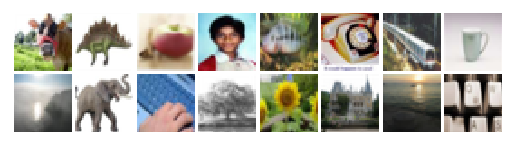

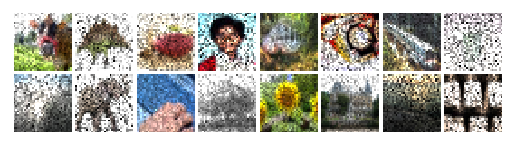

In [2]:
def add_noise(x):
    noise_amount = 0.1+0.3 * torch.rand(len(x)).to(device)
    noised = torch.normal(
       mean=torch.ones([1, 1, *x.shape[2:]], device=device),
       std=noise_amount.view(len(x), 1, 1, 1))
    return torch.clamp(x*noised, 0.0, 1.0)


traindata = datasets.CIFAR100('data', train=True, download=True, transform=transforms.ToTensor())
testdata = datasets.CIFAR100('data', train=False, download=True, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(traindata, batch_size=16)

for x, y in dataloader:
    x = x.to(device)
    break

def plot_imgs(x):
    plt.figure()
    plt.imshow(np.transpose(vutils.make_grid(x[:16].cpu(),
        padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

plot_imgs(x)
plot_imgs(add_noise(x))

In [3]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=False)

def relu(x):
    return F.relu(x, inplace=True)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = conv3(1, 8)
        self.conv2 = conv3(8, 8)
        self.conv3 = conv3(8, 1)

    def forward1(self, input):
        x = input
        c1 = self.conv1(x)
        x = relu(c1)
        c2 = self.conv2(x)
        x = relu(c2)
        c3 = self.conv3(x)
        return c3+input

    def forward(self, input):
        return torch.cat((
            self.forward1(input[:, 0:1]),
            self.forward1(input[:, 1:2]),
            self.forward1(input[:, 2:3])
        ), 1)

model = Model().to(device)
print(model)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)


1000 0.045041292905807495 0.04940114542841911


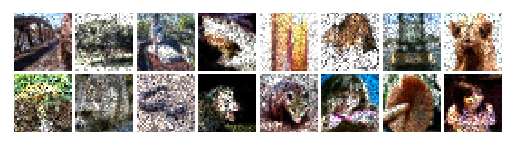

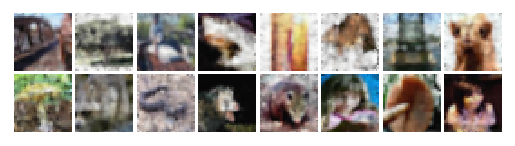

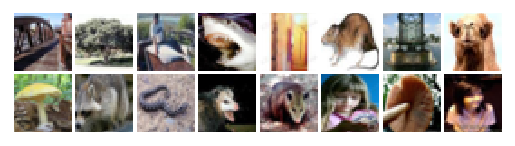

2000 0.03882608190178871 0.04519148916006088


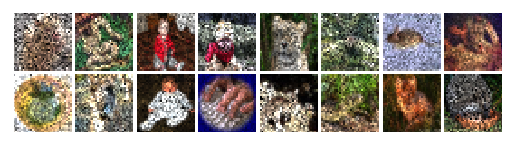

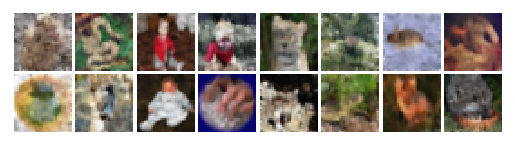

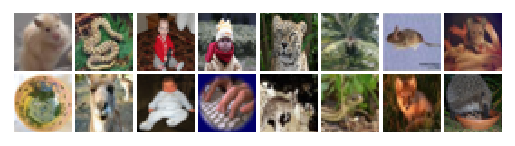

3000 0.045264869928359985 0.04225984215736389


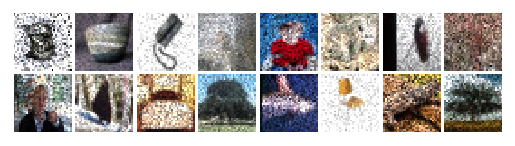

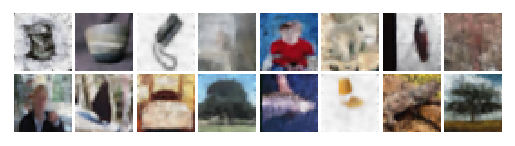

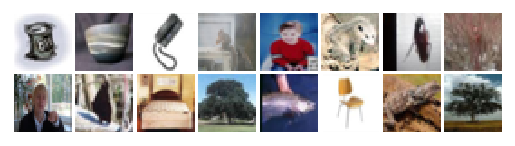

4000 0.050434410572052 0.04701509326696396


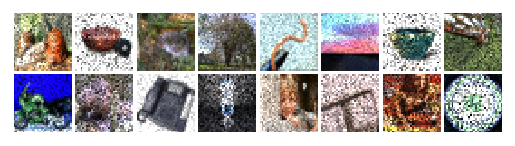

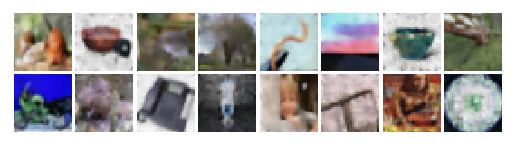

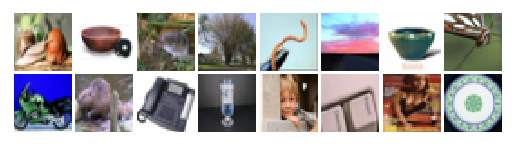

5000 0.04502103850245476 0.05184869095683098


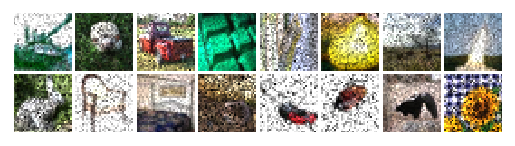

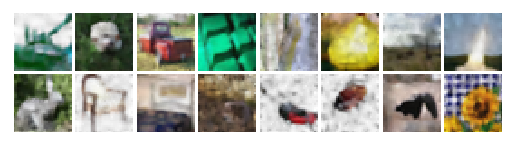

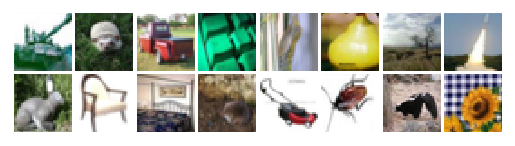

6000 0.04618660733103752 0.04429992288351059


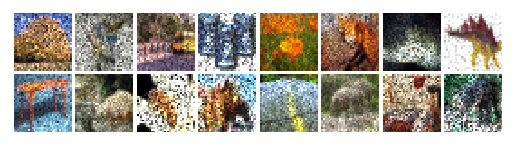

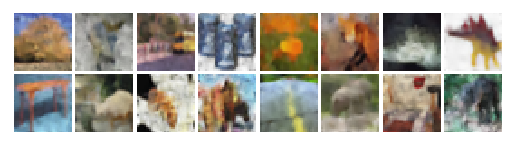

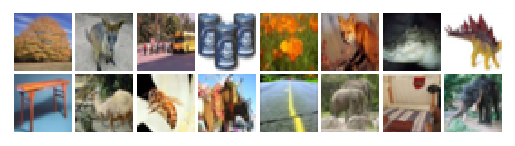

7000 0.04040589928627014 0.04286962002515793


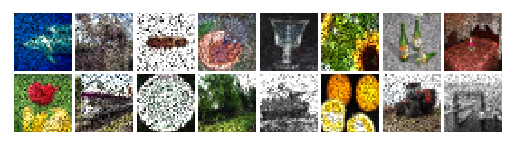

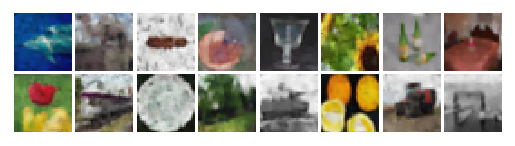

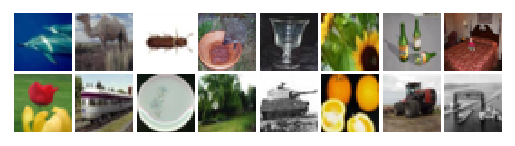

8000 0.044380538165569305 0.03684711083769798


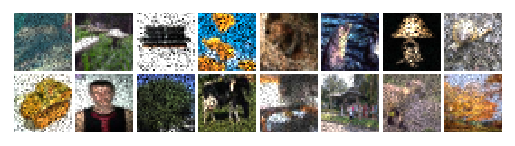

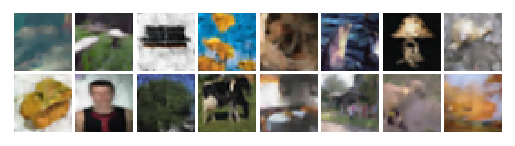

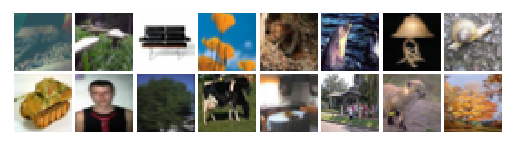

9000 0.04665646702051163 0.03794942423701286


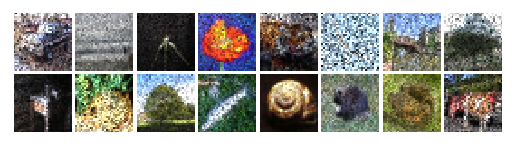

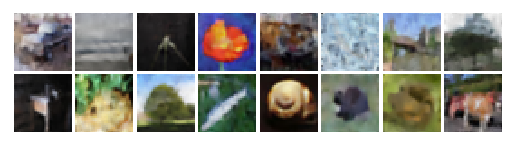

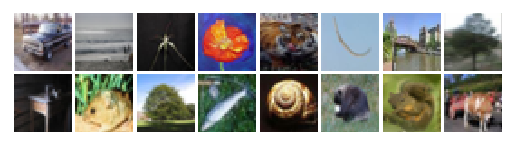

10000 0.048285387456417084 0.04836653172969818


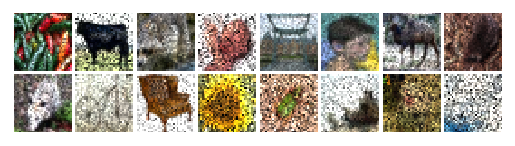

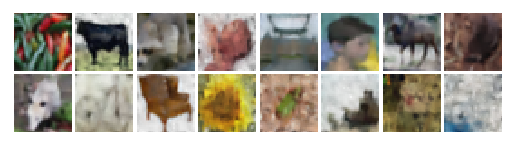

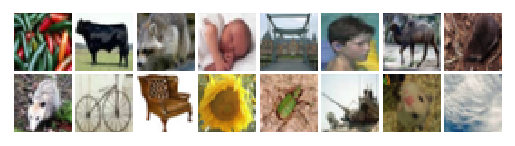

11000 0.049531739205121994 0.04137542098760605


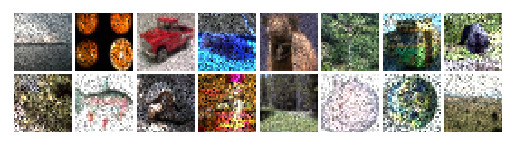

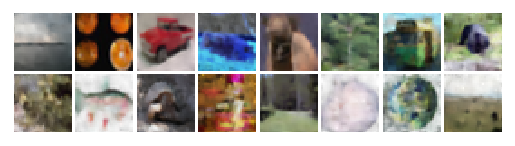

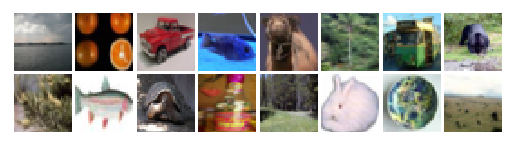

12000 0.04018239676952362 0.050523869693279266


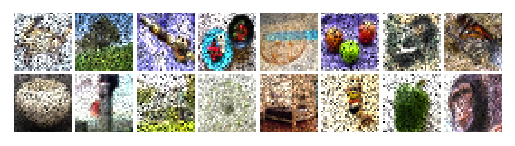

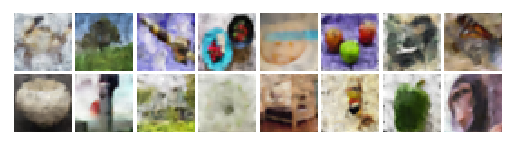

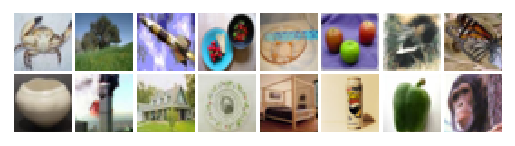

13000 0.04666956886649132 0.04726415127515793


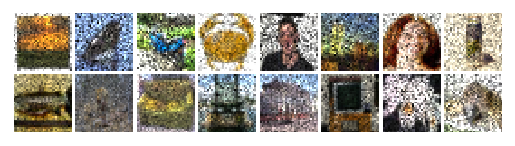

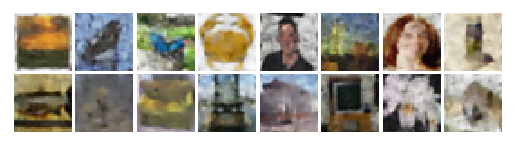

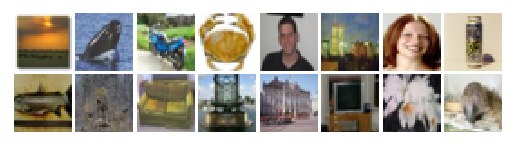

14000 0.04222232848405838 0.04024580493569374


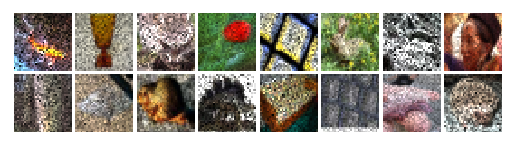

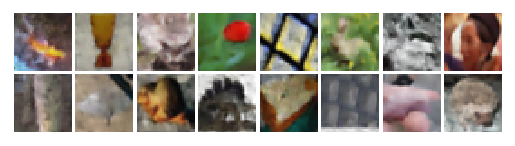

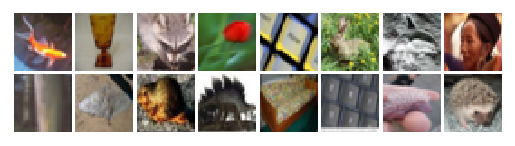

15000 0.038732774555683136 0.044995248317718506


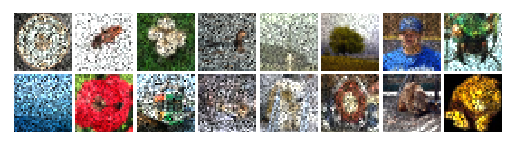

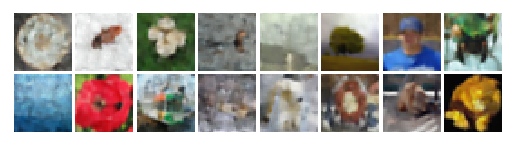

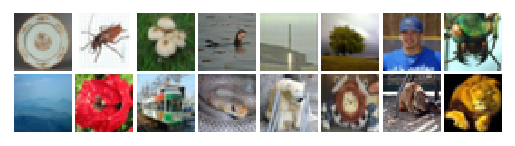

In [4]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005
)

def lossfun(x, y):
    return torch.mean(torch.abs(y-x))

batch_count = 0
for epoch in range(5):
    trainloader = torch.utils.data.DataLoader(traindata, batch_size=16)
    for images, label in trainloader:
        images = images.to(device)
        noised = add_noise(images)
        optimizer.zero_grad()
        output = model(noised)
        loss = lossfun(output, images)
        loss.backward()
        optimizer.step()

        batch_count += 1
        if batch_count % 1000 == 0:
            testloader = torch.utils.data.DataLoader(
                testdata, batch_size=16, shuffle=True)
            with torch.no_grad():
                for images, label in testloader:
                    images = images.to(device)
                    noised = add_noise(images)
                    output = model(noised)
                    loss1 = lossfun(output, images)
                    print(batch_count, loss.item(), loss1.item())
                    plot_imgs(noised)
                    plot_imgs(output)
                    plot_imgs(images)
                    break
